# Text Analysis to Infer Personality


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install -r requirements.txt

In [ ]:
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import plotly.express as px
 #for worcloud  and sentiment analysis 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
#for BERT 
from transformers import TFDistilBertModel
seed_value = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
np.set_printoptions(precision=2)
import tensorflow as tf
tf.random.set_seed(seed_value)
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
import pickle


In [ ]:
!pip install vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
from google.colab import files
uploaded = files.upload()

## Data Exploration

In [ ]:
df = pd.read_csv("mbti.csv")

In [ ]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
df.isnull().any() #there are no nas 
df.describe(include=['object']) #present all 16 type, INFP is the most frequent class, there are no repetead posts

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'We are having a baby in ONE MONTH! Crazy how ...
freq,1832,1


Distribution of 16 MBTI categories in the dataset: 

In [ ]:
df_type=df.groupby("type") #Group by Briggs personality type 
types = np.unique(np.array(df['type'])) # unique values from the 'type' column
total=df_type.count().sort_values(by=['posts']) 
print(total)

      posts
type       
ESTJ     39
ESFJ     42
ESFP     48
ESTP     89
ISFJ    166
ENFJ    190
ISTJ    205
ENTJ    231
ISFP    271
ISTP    337
ENFP    675
ENTP    685
INTJ   1091
INTP   1304
INFJ   1470
INFP   1832


Text(0, 0.5, 'Number of posts ')

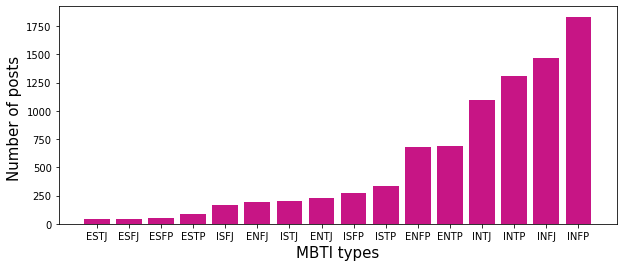

In [ ]:
# no. of posts for each personality type:
plt.figure(figsize = (10,4))
plt.bar(np.array(total.index), height = total['posts'],color='mediumvioletred')
plt.xlabel('MBTI types', size = 15)
plt.ylabel('Number of posts ', size = 15) # we can see that data actually are not equal distributed from each types

## Wordclouds

ESTJ


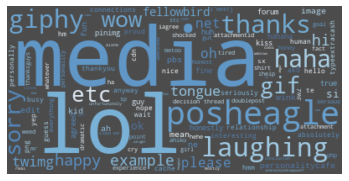

ESFJ


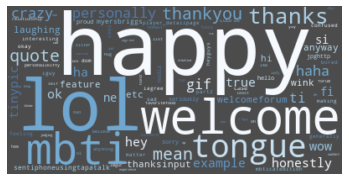

ESFP


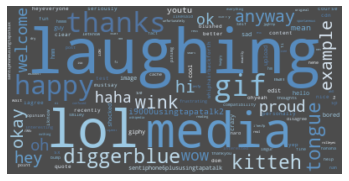

ESTP


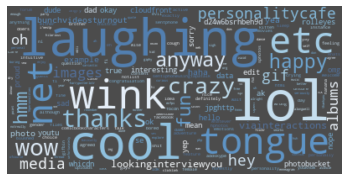

ISFJ


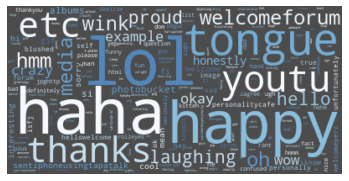

ENFJ


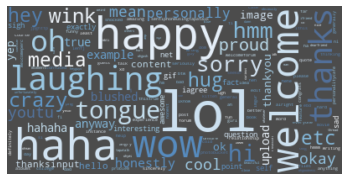

ISTJ


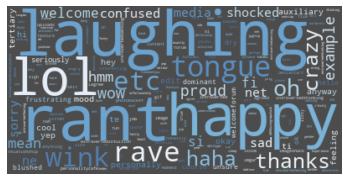

ENTJ


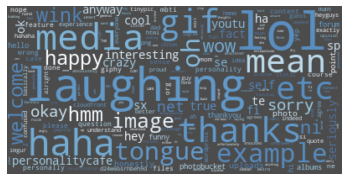

ISFP


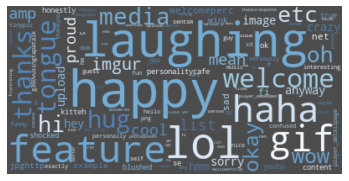

ISTP


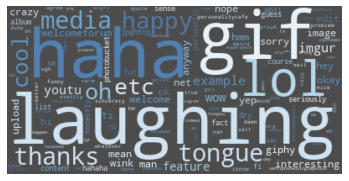

ENFP


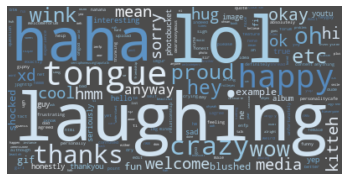

ENTP


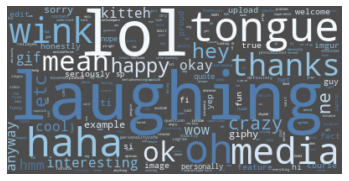

INTJ


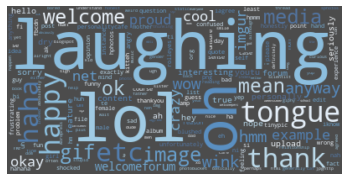

INTP


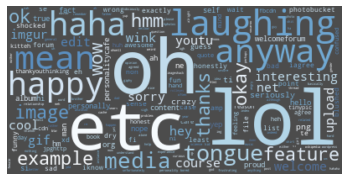

INFJ


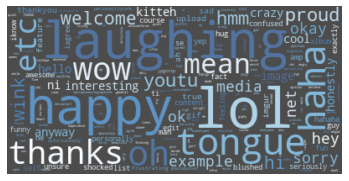

INFP


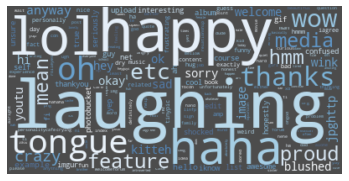

In [ ]:
names = np.array(total.index) #unique list of values in type column
stop_words = set(STOPWORDS)
#add each lower case personality type as a stopword
for word in names:
    word.lower()
    stop_words.add(word.lower())
#Remove all of the most common words
more_words =['lot', 'time', 'love', 'actually', 'seem', 'need', 'infj', 'actually', 'pretty', 'sure', 'thought','type', 'one', 'even', 'someone', 'thing','make', 
            'now', 'see', 'things', 'feel', 'think', 'i', 'people', 'know', '-', "much", "something", "will", "find", "go", "going", "need", 'still', 'though', 
            'always', 'through', 'lot', 'time', 'love', 'really', 'want', 'way', 'never', 'find', 'say', 'it.', 'good', 'me.', 'many', 'first', 'wp', 'go', 
            'really', 'much', 'why', 'youtube', 'right', 'know', 'want', 'tumblr', 'great', 'say', 'well', 'people', 'will', 'something', 'way', 'sure', 
            'especially', 'thank', 'friend', 'good', 'ye', 'person', 'https', 'watch', 'yes', 'got', 'take', 'person', 'life', 'might', 'me', 'me,', 'around', 'best', 'try', 
            'maybe', 'probability', 'usually', 'sometimes', 'trying', 'read', 'us', 'may', 'use', 'work', ':)', 'said', 'two', 'makes', 'little', 'quite','fe', 'u', 'intps', 'probably', 'made', 'it', 'seems', 'look', 'yeah',
           'different', 'come', 'it,', 'friends', 'entps', 'different', 'esfjs', 'look', 'infjs', 'estps', 'kind', 'intjs', 'enfjs', 
            'entjs', 'infps', 'every', 'long', 'tell', 'new', 'jpg']

for i in more_words:
    stop_words.add(i)  
    

i = 0
while i < len(names):
    for name in names:
        print(name)
        #filter by type
        spec_type = df['type'] == name
        #combine the rows by type
        name_return = "".join(post for post in df[df["type"]== name].posts)
        name_return = name_return.lower()
        #make into a list to use comprehension to remove stopwords
        split = name_return.split()
        filt_list = [word for word in split if word not in stop_words]
        filt_words = "".join(filt_list)
        #collocations = false to prevent duplicate words
        wordcloud = WordCloud( background_color="black", stopwords=stop_words, collocations=False, colormap="Blues").generate(filt_words)
        plt.imshow(wordcloud,cmap ="Reds", alpha = 0.7, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        i +=1     

## Sentiment Analysis

Text preprocessing:

In [ ]:
 
df['posts'] = df['posts'].replace(to_replace = r'\|\|\|', value = r';',regex=True)  #Replace post separator ||| with semi-colon ;


pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'  # Replace all http links with 'url'
subs_url = r'url'
df['posts'] = df['posts'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [ ]:
df.head()

,type,posts
0,INFJ,'url and intj moments url sportscenter not t...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,"'Good one _____ url course, to which I say ..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.;That's another silly misconcept...


Implement the function that allows VADER to calculate the overall sentiment score of a sentence: 

In [ ]:
def sentiment_scores(sentence):  
    sid_obj = SentimentIntensityAnalyzer()   # Create a SentimentIntensityAnalyzer object
    sentiment_dict = sid_obj.polarity_scores(sentence)  # polarity_scores method  gives a sentiment dictionary which contains how pos/ neg/ neu a sentence is and compound scores
    return sentiment_dict['compound']  #we are only interested in the compound score 

Apply the function on each row of the posts column, the sentiment score of each post is saved in a new column:

In [ ]:
df["Sentiment Score"] = df["posts"].apply(sentiment_scores)
df.head()

,type,posts,Sentiment Score
0,INFJ,'url and intj moments url sportscenter not t...,0.9871
1,ENTP,'I'm finding the lack of me in these posts ver...,0.9994
2,INTP,"'Good one _____ url course, to which I say ...",0.9985
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0.9966
4,ENTJ,'You're fired.;That's another silly misconcept...,0.9725


Average all the sentiment scores by each of the unique 16 MBTI types and see if a type is associated with a positive, negative or neutral sentiment:

In [ ]:
for personality,value in df.groupby('type')['Sentiment Score'].mean().items():
    if value >= 0.05 :
        print(personality, " has a mean positive sentiment.")

    elif value <= - 0.05 :
        print(personality, " has a mean negative sentiment.")

    else :
        print(personality, " has a mean neutral sentiment.")

ENFJ  has a mean positive sentiment.
ENFP  has a mean positive sentiment.
ENTJ  has a mean positive sentiment.
ENTP  has a mean positive sentiment.
ESFJ  has a mean positive sentiment.
ESFP  has a mean positive sentiment.
ESTJ  has a mean positive sentiment.
ESTP  has a mean positive sentiment.
INFJ  has a mean positive sentiment.
INFP  has a mean positive sentiment.
INTJ  has a mean positive sentiment.
INTP  has a mean positive sentiment.
ISFJ  has a mean positive sentiment.
ISFP  has a mean positive sentiment.
ISTJ  has a mean positive sentiment.
ISTP  has a mean positive sentiment.


## Text classification: BERT


Start to implement the  model:

In [ ]:
#define the parameters 
N_AXIS = 4
MAX_SEQ_LEN = 128
BERT_NAME = 'distilbert-base-uncased'   #type of BERT model
axes = ["I-E","N-S","T-F","J-P"]
classes = {"I":0, "E":1, # axis 1   #we have 4 binary classifications 
           "N":0,"S":1, # axis 2
           "T":0, "F":1, # axis 3
           "J":0,"P":1} # axis 4

    

In [ ]:
#Create the function to obtain the data to feed the transformer with, the function includes the labels encoding :

def get_data(train_n=6624, val_n=1024, test_n=1024): #set the splitting in this way since it is better that the train set
                                                      #is multiple of the batches number 
    data = df.sample(frac=1)  #note: before implement this, the dataset has been reloaded to avoid the previous operations of text preprocessing 
    labels = []
    print(data)
    for personality in data["type"]:
        pers_vect = []
        for p in personality:
            pers_vect.append(classes[p])
        labels.append(pers_vect)
    sentences = data["posts"].str.lower()
    labels = np.array(labels, dtype="float32")
    train_sentences = sentences[:train_n]
    y_train = labels[:train_n]
    val_sentences = sentences[train_n:train_n+val_n]
    y_val = labels[train_n:train_n+val_n]
    test_sentences = sentences[train_n+val_n:train_n+val_n+test_n]
    y_test = labels[train_n+val_n:train_n+val_n+test_n]
    return train_sentences, y_train, val_sentences, y_val, test_sentences, y_test

In [ ]:

def create_model():
    input_ids = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_ids')
    #input_type = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='token_type_ids') #not necessary for this type of BERT 
    input_mask = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='attention_mask')
    inputs = [input_ids, input_mask]
    bert = TFDistilBertModel.from_pretrained(BERT_NAME)
    bert_outputs = bert(inputs)
    last_hidden_states = bert_outputs.last_hidden_state
    avg = layers.GlobalAveragePooling1D()(last_hidden_states)
    output = layers.Dense(N_AXIS, activation="sigmoid")(avg) 
    model = keras.Model(inputs=inputs, outputs=output)
    model.summary()
    return model

In [ ]:
def fine_tune(model, X_train, x_val, y_train, y_val):
    max_epochs = 7
    batch_size = 32
    opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)  #low learning rate because this is transfer learning  
    loss = keras.losses.BinaryCrossentropy()
    best_weights_file = "weights.h5"
    m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_auc', mode='max', verbose=2,
                             save_weights_only=True, save_best_only=True)
    model.compile(loss=loss, optimizer=opt, metrics=[keras.metrics.AUC(multi_label=True, curve="ROC"),
                                                     keras.metrics.BinaryAccuracy()])
    model.fit(
        X_train, y_train,
        validation_data=(x_val, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[m_ckpt],
        verbose=2
    )

In [ ]:
def load_model():
    model = create_model()
    loss = keras.losses.BinaryCrossentropy()
    best_weights_file = "weights.h5"
    model.load_weights(best_weights_file)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
    model.compile(loss=loss, optimizer=opt, metrics=[keras.metrics.AUC(multi_label=True, curve="ROC"),
                                                     keras.metrics.BinaryAccuracy()])
    return model

Extract of the MBTI data that will feed BERT:

In [ ]:
train_sentences, y_train, val_sentences, y_val, test_sentences, y_test = get_data()

      type                                              posts
2802  INTP  'This. When I lie it's to avoid an unreasonabl...
2166  INTJ  'I said zero flexibility and little time for d...
1919  INTP  'This has to be written with bias or something...
360   ENFP  'HAuhuHAuh You might be right Muhicz. I'm just...
1115  ENTJ  'Her parents are kind of the go to college = g...
...    ...                                                ...
5734  INFP  'I have 2 cats and a chihuahua/pug mix. It's r...
5191  INFP  Ever since I can remember I have suffered/live...
5390  INFJ  'I've known a couple of INFJ guys and they see...
860   INFP  'Even the loner gets lonely. I feel like it's ...
7270  INTJ  Before reading the responses to this thread, I...

[8675 rows x 2 columns]


Encode the sentences into vectors by following the BERT specifications:

In [ ]:
import numpy as np
from transformers import BertTokenizer, DistilBertTokenizer


def prepare_distilbert_input(sentences, seq_len, bert_name):
    tokenizer = DistilBertTokenizer.from_pretrained(bert_name)
    encodings = tokenizer(sentences.tolist(), truncation=True, padding='max_length',
                                max_length=seq_len)
    input = [np.array(encodings["input_ids"]), np.array(encodings["attention_mask"])]
    return input

In [ ]:
X_train = prepare_distilbert_input(train_sentences, MAX_SEQ_LEN, BERT_NAME)
X_val = prepare_distilbert_input(val_sentences, MAX_SEQ_LEN, BERT_NAME)
X_test = prepare_distilbert_input(test_sentences, MAX_SEQ_LEN, BERT_NAME)

In [ ]:
#save X_train, X_val, X_test:
pickle.dump(X_train, open("X_train.p", "wb"))
pickle.dump(X_val, open("X_val.p", "wb"))
pickle.dump(X_test, open("X_test.p", "wb"))

Create the classification model:

In [ ]:
model = create_model() #we can ignore the warnings 

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 768)          0           tf_distil_bert_model_1[0][0] 

Tune the full model on our specific data:

In [ ]:
fine_tune(model, X_train, X_val, y_train, y_val)

Epoch 1/7
207/207 - 111s - loss: 0.5931 - auc: 0.5238 - binary_accuracy: 0.6770 - val_loss: 0.5746 - val_auc: 0.5928 - val_binary_accuracy: 0.6941

Epoch 00001: val_auc improved from -inf to 0.59284, saving model to weights.h5
Epoch 2/7
207/207 - 100s - loss: 0.5455 - auc: 0.6379 - binary_accuracy: 0.7285 - val_loss: 0.5262 - val_auc: 0.6989 - val_binary_accuracy: 0.7471

Epoch 00002: val_auc improved from 0.59284 to 0.69892, saving model to weights.h5
Epoch 3/7
207/207 - 101s - loss: 0.5015 - auc: 0.7324 - binary_accuracy: 0.7585 - val_loss: 0.5047 - val_auc: 0.7238 - val_binary_accuracy: 0.7617

Epoch 00003: val_auc improved from 0.69892 to 0.72380, saving model to weights.h5
Epoch 4/7
207/207 - 101s - loss: 0.4624 - auc: 0.7867 - binary_accuracy: 0.7845 - val_loss: 0.5262 - val_auc: 0.7327 - val_binary_accuracy: 0.7539

Epoch 00004: val_auc improved from 0.72380 to 0.73265, saving model to weights.h5
Epoch 5/7
207/207 - 101s - loss: 0.4125 - auc: 0.8379 - binary_accuracy: 0.8120 - v

Evaluate the model  on the test set:

In [ ]:
model = load_model()
predictions = model.predict(X_test)
model.evaluate(X_test, y_test, batch_size=32)



Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_3 (TFDisti TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_average_pooling1d_3 (Glo (None, 768)          0           tf_distil_bert_model_3[0][0

[0.5284161567687988, 0.7105858325958252, 0.744873046875]

 Final accuracy on the test set is 74%.
 ROC curves for every axis:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

In [ ]:
def plot_roc_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc))
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

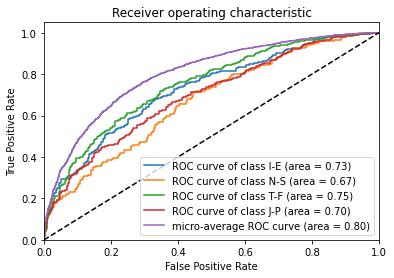

In [ ]:
plot_roc_auc(y_test, predictions, axes) #roc curves for each class 
